# GPyTorch Regression Tutorial

## Introduction

In this notebook, we demonstrate many of the design features of GPyTorch using the simplest example, training an RBF kernel Gaussian process on a simple function. We'll be modeling the function

\begin{align*}
  y &= \sin(2\pi x) + \epsilon \\
  \epsilon &\sim \mathcal{N}(0, 0.2)
\end{align*}

with 11 training examples, and testing on 51 test examples.

**Note:** this notebook is not necessarily intended to teach the mathematical background of Gaussian processes, but rather how to train a simple one and make predictions in GPyTorch. For a mathematical treatment, Chapter 2 of Gaussian Processes for Machine Learning provides a very thorough introduction to GP regression (this entire text is highly recommended): http://www.gaussianprocess.org/gpml/chapters/RW2.pdf

In [1]:
import math
import torch
import gpytorch
from gpytorch.kernels import ScaleKernel
from gpytorch.kernels.spectral_autoregressive_flow_kernel import RFNSSpectralNFKernel, RFNSSpectralDeltaKernel
from gpytorch.mlls import ExactMarginalLogLikelihood
from matplotlib import pyplot as plt

# torch.set_default_dtype(torch.float64)
%set_env CUDA_VISIBLE_DEVICES=1

%matplotlib inline
%load_ext autoreload
%autoreload 2

env: CUDA_VISIBLE_DEVICES=1


In [2]:
x_test, y_test, train_x, train_y, test_x, test_y = torch.load('synthetic_spiral')

In [3]:


# n_pts, n_periods = 1000, 1
# theta = torch.linspace(0., (2 * math.pi * n_periods) ** 2, n_pts).sqrt()
# r = theta.unsqueeze(-1) / theta.max()
# X = r * torch.stack((torch.cos(theta), torch.sin(theta)), dim=-1)
# X = X + 1
# X_noisy = X + 0.02 * torch.randn(X.shape)

# plt.scatter(X_noisy[:, 0], X_noisy[:, 1])

# class ExactGPModel(gpytorch.models.ExactGP):
#     def __init__(self, train_x, train_y, deltas, likelihood):
#         super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
# #         self.mean_module = gpytorch.means.LinearMean(1)
#         self.mean_module = gpytorch.means.ConstantMean()
#         base_covar_module = RFNSSpectralDeltaKernel(
#             num_dims=2,
#             num_deltas=1000,
#             nonstationary=False,
#         )
        
#         base_covar_module.lengthscale = 0.4
#         base_covar_module.Z = deltas
        
#         self.covar_module = ScaleKernel(base_covar_module)
#     def forward(self, x):
#         mean_x = self.mean_module(x)
#         covar_x = self.covar_module(x)
#         return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

# likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-10)).cuda()
# likelihood.register_prior("noise_prior", gpytorch.priors.HorseshoePrior(0.1), "noise")
# likelihood.noise = 1e-2
# # likelihood.noise_covar.raw_noise.requires_grad_(False)
# model = ExactGPModel(None, None, X_noisy, likelihood)

In [4]:
# model.eval()
# N = 100
# xv, yv = torch.meshgrid([torch.linspace(0, 3, N), torch.linspace(0, 3, N)])
# x_test = torch.cat([xv.reshape(N*N, 1), yv.reshape(N*N, 1)], dim=-1)
# with gpytorch.settings.prior_mode(), torch.no_grad():
#     y_test = model(x_test).rsample()

In [5]:
# plt.contour(x_test[:, 0].view(N, N), x_test[:, 1].view(N, N), y_test.detach().view(N, N))

In [6]:
# train_inds = torch.nonzero(~(torch.norm(x_test - torch.tensor([1.5, 1.5]), p=2, dim=-1) <= 0.5)).squeeze()
# test_inds = torch.nonzero((torch.norm(x_test - torch.tensor([1.5, 1.5]), p=2, dim=-1) <= 0.5)).squeeze()

# train_x = x_test[train_inds].cuda()
# train_y = y_test[train_inds].cuda()
# test_x = x_test[test_inds].squeeze().cuda()
# test_y = y_test[test_inds].squeeze().cuda()

In [7]:
# import numpy as np

# y_test_blanked = y_test.clone()
# y_test_blanked[test_inds] = np.nan
# plt.contour(x_test[:, 0].view(N, N), x_test[:, 1].view(N, N), y_test_blanked.detach().view(N, N))

In [8]:
print(train_x.shape, train_y.shape, test_x.shape, test_y.shape)

torch.Size([9152, 2]) torch.Size([9152]) torch.Size([848, 2]) torch.Size([848])


In [9]:
class ExactGPModel(gpytorch.models.ExactGP):
    def __init__(self, train_x, train_y, likelihood):
        super(ExactGPModel, self).__init__(train_x, train_y, likelihood)
#         self.mean_module = gpytorch.means.LinearMean(1)
        self.mean_module = gpytorch.means.ConstantMean()
#         base_covar_module = RFNSSpectralDeltaKernel(
#             num_dims=2,
#             num_deltas=100,
#             nonstationary=False,
#         )
#         base_covar_module.Z = X_noisy
#         base_covar_module.raw_Z.requires_grad_(False)
#         other_feat_covar = gpytorch.kernels.MaternKernel(active_dims=range(1, train_x.size(-1)))
#         base_covar_module.initialize_from_data(train_x[:, :1], train_y)
        base_covar_module = gpytorch.kernels.SpectralMixtureKernel(num_mixtures=7, ard_num_dims=2)
        base_covar_module.initialize_from_data(train_x.cpu(), train_y.cpu())
    
#         smk.mixture_scales = 30
#         smk.mixture_weights = 0.01
        
        self.covar_module = ScaleKernel(base_covar_module)
    def forward(self, x):
        mean_x = self.mean_module(x)
        covar_x = self.covar_module(x)
        return gpytorch.distributions.MultivariateNormal(mean_x, covar_x)

likelihood = gpytorch.likelihoods.GaussianLikelihood(noise_constraint=gpytorch.constraints.GreaterThan(1e-10)).cuda()
likelihood.register_prior("noise_prior", gpytorch.priors.HorseshoePrior(0.1), "noise")
likelihood.noise = 1e-2
# likelihood.noise_covar.raw_noise.requires_grad_(False)
model = ExactGPModel(train_x, train_y, likelihood).cuda()

In [10]:
import pyro

pyro.clear_param_store()

model.train()
likelihood.train()
mll = ExactMarginalLogLikelihood(model.likelihood, model)

optimizer = torch.optim.Adam(model.parameters(), lr=0.1)
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer=optimizer, milestones=[50])
with gpytorch.settings.max_cholesky_size(0), gpytorch.settings.num_spectral_samples(2000):
    for i in range(1000):
        optimizer.zero_grad()
        output = model(train_x)
        loss = -mll(output, train_y).mean()
        loss.backward()
        optimizer.step()
        if i % 10 == 0:
            print(f'Iteration {i} - loss = {loss:.2f} - noise = {likelihood.noise.mean().item():e}')
        
        scheduler.step()

RuntimeError: CUDA out of memory. Tried to allocate 4.37 GiB (GPU 0; 11.00 GiB total capacity; 4.37 GiB already allocated; 4.32 GiB free; 1.85 MiB cached)

In [15]:
torch.cuda.empty_cache()

In [203]:
# Get into evaluation (predictive posterior) mode
model.eval()
likelihood.eval()

# Test points are regularly spaced along [0,1]
# Make predictions by feeding model through likelihood
with torch.no_grad(), gpytorch.settings.max_cholesky_size(0), gpytorch.settings.fast_pred_var():
    test_x_f = torch.cat([train_x, test_x], dim=-2)
    observed_pred = model.likelihood(model(test_x_f))
    varz = observed_pred.variance

c:\users\gardn\gpytorch\gpytorch\utils\linear_cg.py:315: UserWarning: CG terminated in 1000 iterations with average residual norm 0.07442323863506317 which is larger than the tolerance of 0.01 specified by gpytorch.settings.cg_tolerance. If performance is affected, consider raising the maximum number of CG iterations by running code in a gpytorch.settings.max_cg_iterations(value) context.
  " a gpytorch.settings.max_cg_iterations(value) context.".format(k + 1, residual_norm.mean(), tolerance)


In [223]:
model.eval()
with torch.no_grad(), gpytorch.settings.max_cholesky_size(0), gpytorch.settings.fast_pred_var():
    mu_test = model.likelihood(model(test_x)).mean

## Plot the model fit


In the next cell, we plot the mean and confidence region of the Gaussian process model. The `confidence_region` method is a helper method that returns 2 standard deviations above and below the mean.

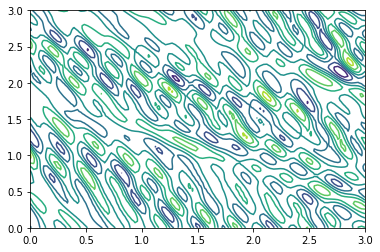

In [232]:
import numpy as np

y_test_blanked = y_test.clone()
y_test_blanked[test_inds] = mu_test.cpu().detach()
plt.contour(x_test[:, 0].view(N, N), x_test[:, 1].view(N, N), y_test_blanked.detach().view(N, N))

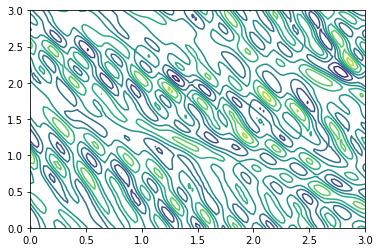

In [207]:
plt.contour(x_test[:, 0].view(N, N), x_test[:, 1].view(N, N), y_test.detach().view(N, N))

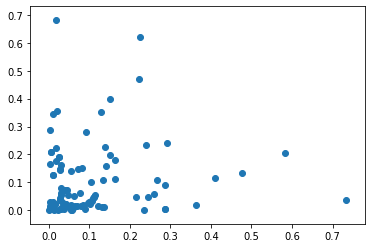

In [231]:
plt.scatter(model.covar_module.base_kernel.Z[:, 0].cpu().detach(), model.covar_module.base_kernel.Z[:, 1].cpu().detach())

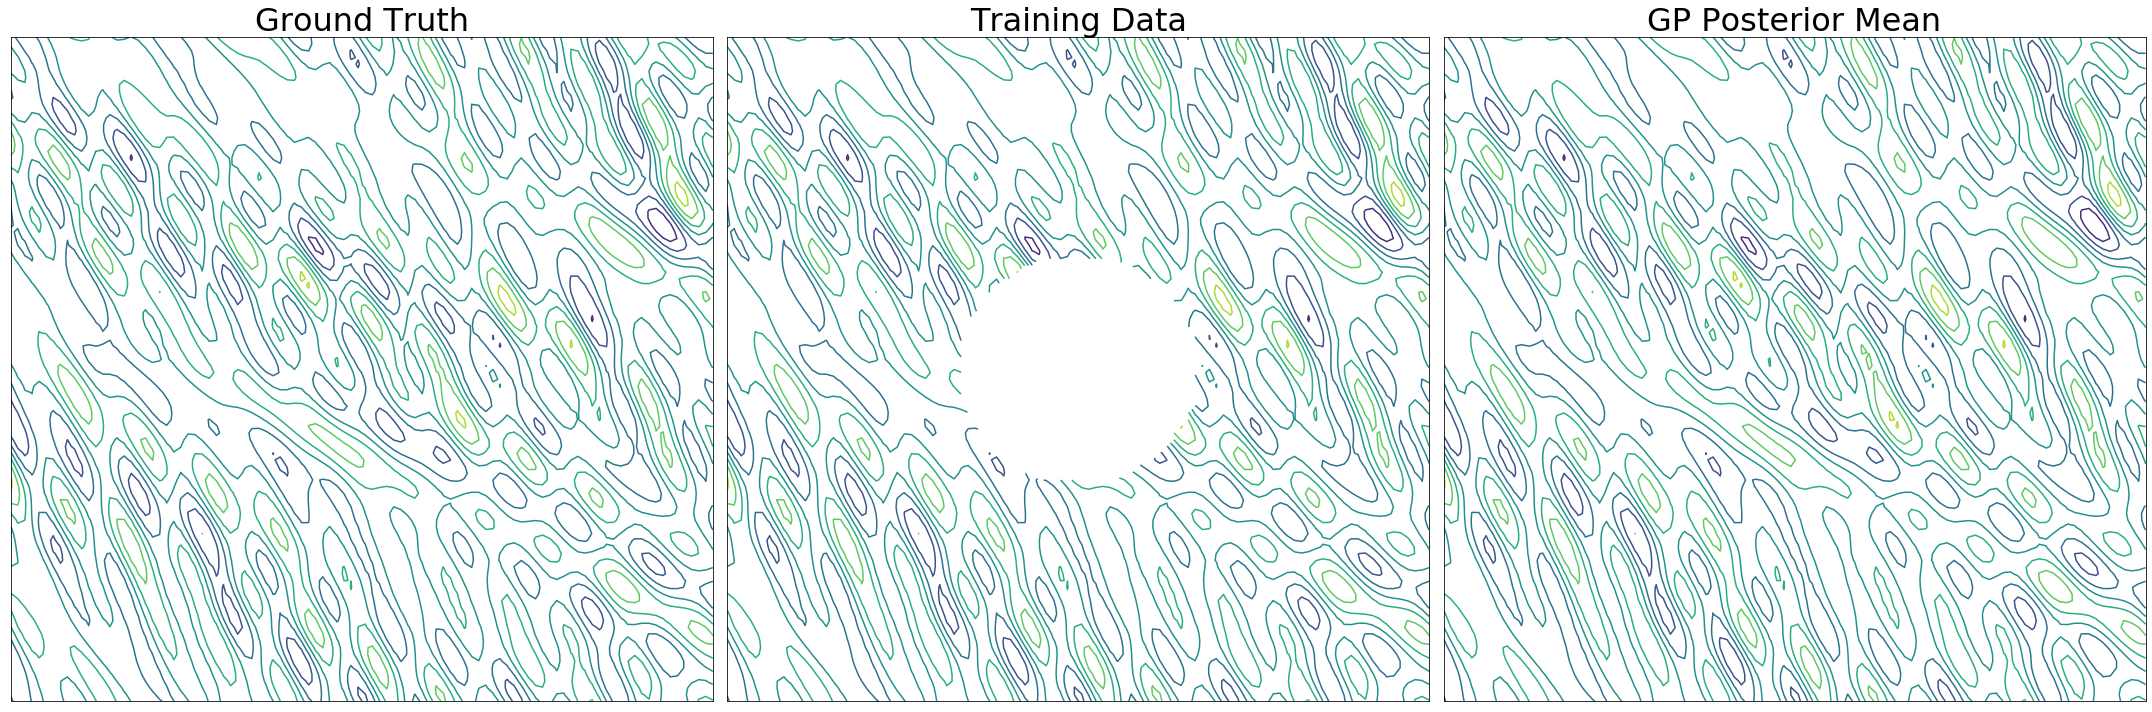

In [233]:
import numpy as np

plt.figure(figsize=(30, 10))

ax = plt.subplot(1, 3, 1)
ax.contour(x_test[:, 0].view(N, N), x_test[:, 1].view(N, N), y_test.detach().view(N, N))

plt.xticks([])
plt.yticks([])
plt.title('Ground Truth', fontsize=32)
ax = plt.subplot(1, 3, 2)
y_test_blanked = y_test.clone()
y_test_blanked[test_inds] = np.nan
ax.contour(x_test[:, 0].view(N, N), x_test[:, 1].view(N, N), y_test_blanked.detach().view(N, N))

plt.xticks([])
plt.yticks([])
plt.title('Training Data', fontsize=32)
ax = plt.subplot(1, 3, 3)

y_test_blanked = y_test.clone()
y_test_blanked[test_inds] = mu_test.cpu().detach()
plt.contour(x_test[:, 0].view(N, N), x_test[:, 1].view(N, N), y_test_blanked.detach().view(N, N))
plt.xticks([])
plt.yticks([])
plt.title('GP Posterior Mean', fontsize=32)

plt.tight_layout()
plt.savefig('synthetic_hard.pdf', bbox_inches=0)

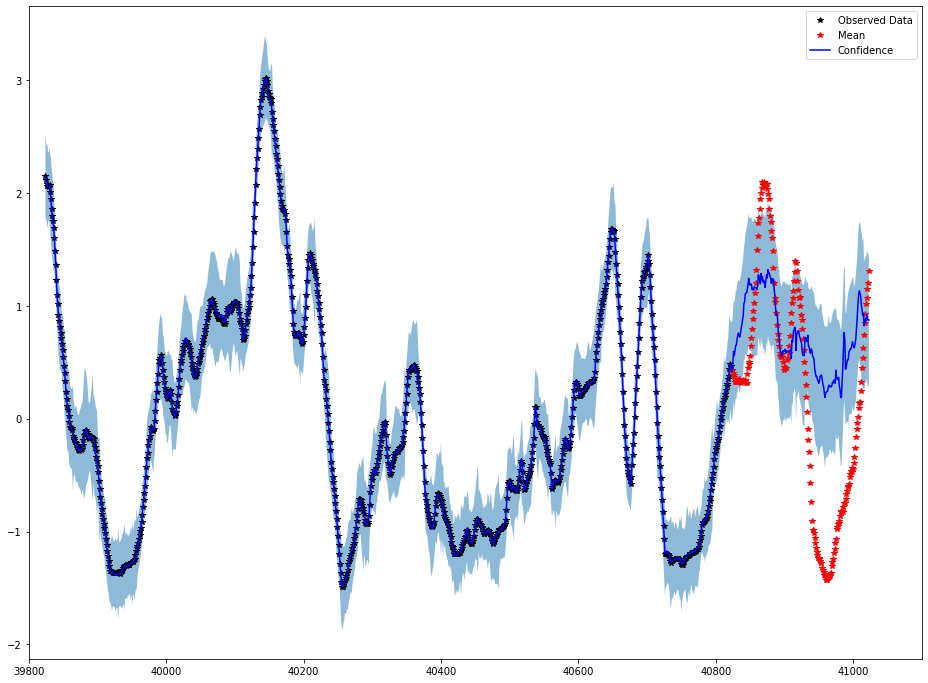

In [144]:
with torch.no_grad():
    # Initialize plot
    f, ax = plt.subplots(1, 1, figsize=(16, 12))

    # Get upper and lower confidence bounds
    lower, upper = observed_pred.confidence_region()
    # Plot training data as black stars
    ax.plot(train_x[:, 0].detach().cpu().numpy(), train_y.detach().cpu().numpy(), 'k*')
    ax.plot(test_x[:, 0].detach().cpu().numpy(), (test_y + 0.01 * torch.randn_like(test_y)).detach().cpu().numpy(), 'r*')
    # Plot predictive means as blue line
    ax.plot(test_x_f[:, 0].detach().cpu().numpy(), observed_pred.mean.detach().cpu().numpy(), 'b')
    # Shade between the lower and upper confidence bounds
    ax.fill_between(test_x_f[:, 0].detach().cpu().squeeze().numpy(), lower.detach().cpu().numpy(), upper.detach().cpu().numpy(), alpha=0.5)
#     ax.set_ylim([-3, 3])
    ax.legend(['Observed Data', 'Mean', 'Confidence'])
    plt.xlim([39800, 41100])

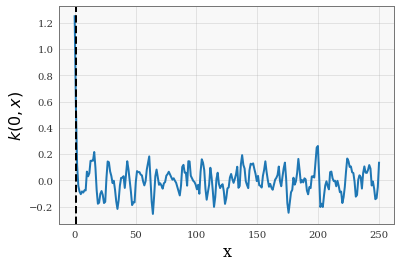

In [65]:
with torch.no_grad():
    xr = torch.linspace(0, 250, 250).cuda()
    plt.plot(xr.cpu().numpy(), model.covar_module(torch.tensor([0]).cuda(), xr).evaluate().detach().cpu().squeeze().numpy())
    plt.axvline(1.0, linestyle='--', color='k')
    plt.ylabel('$k(0, x)$', fontsize=16)
    plt.xlabel('x', fontsize=16)

(array([1.000e+00, 1.244e+03, 4.520e+02, 6.900e+01, 8.100e+01, 1.220e+02,
        2.100e+01, 3.900e+01, 6.000e+00, 3.000e+00, 1.000e+00, 0.000e+00,
        0.000e+00, 1.000e+00, 1.000e+00, 1.000e+00, 2.000e+00, 2.000e+00,
        1.000e+00, 1.000e+00]),
 array([7.69715573e-06, 5.64711659e-02, 1.12934635e-01, 1.69398104e-01,
        2.25861572e-01, 2.82325041e-01, 3.38788510e-01, 3.95251979e-01,
        4.51715448e-01, 5.08178916e-01, 5.64642385e-01, 6.21105854e-01,
        6.77569323e-01, 7.34032791e-01, 7.90496260e-01, 8.46959729e-01,
        9.03423198e-01, 9.59886667e-01, 1.01635014e+00, 1.07281360e+00,
        1.12927707e+00]),
 <a list of 20 Patch objects>)

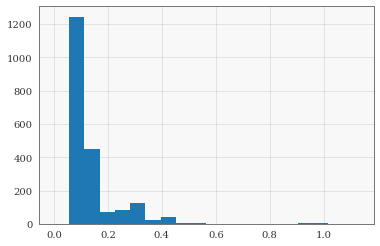

In [28]:
plt.hist(model.covar_module.base_kernel.Z.detach().cpu().numpy(), bins=20)

In [15]:
x0 = torch.tensor([0.]).cuda()
x1 = torch.linspace(0, 10, 500).unsqueeze(-1).cuda()
plt.plot(model.covar_module.forward(x0, x1).squeeze().cpu().detach().numpy())

TypeError: squeeze() missing 1 required positional argument: 'dim'

In [17]:
model.covar_module.lengthscale

tensor([[2.6730]], device='cuda:0', grad_fn=<SoftplusBackward>)

(array([950.,  22.,   0.,   0.,   1.,   0.,   1.,   0.,   0.,   0.,   0.,
          0.,   0.,   0.,   0.,   0.,   2.,   0.,   0.,   0.,   0.,   0.,
          1.,   0.,   0.,   0.,   0.,   0.,   1.,  22.]),
 array([-1.44398087, -1.37944732, -1.31491378, -1.25038023, -1.18584668,
        -1.12131314, -1.05677959, -0.99224604, -0.9277125 , -0.86317895,
        -0.7986454 , -0.73411186, -0.66957831, -0.60504476, -0.54051122,
        -0.47597767, -0.41144412, -0.34691058, -0.28237703, -0.21784348,
        -0.15330994, -0.08877639, -0.02424284,  0.0402907 ,  0.10482425,
         0.1693578 ,  0.23389134,  0.29842489,  0.36295844,  0.42749198,
         0.49202553]),
 <a list of 30 Patch objects>)

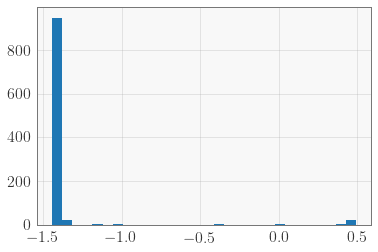

In [65]:
plt.hist(samples[:, 0].cpu().detach().numpy(), bins=30)

(array([340., 127.,   1.,   1.,   0.,   2.,   1.,   1.,   0.,  18.,   0.,
          0.,   0.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,  32., 442.,
         29.,   0.,   0.,   0.,   0.,   1.,   0.,   4.]),
 array([-0.521559  , -0.4539332 , -0.38630741, -0.31868162, -0.25105583,
        -0.18343004, -0.11580425, -0.04817846,  0.01944733,  0.08707312,
         0.15469891,  0.2223247 ,  0.28995049,  0.35757628,  0.42520208,
         0.49282787,  0.56045366,  0.62807945,  0.69570524,  0.76333103,
         0.83095682,  0.89858261,  0.9662084 ,  1.03383419,  1.10145998,
         1.16908577,  1.23671157,  1.30433736,  1.37196315,  1.43958894,
         1.50721473]),
 <a list of 30 Patch objects>)

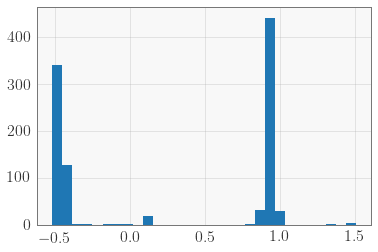

In [66]:
plt.hist(samples[:, 1].cpu().detach().numpy(), bins=30)